<a href="https://colab.research.google.com/github/vladimiralencar/DeepLearning-LANA/blob/master/RNN/RNN_PrevisaoSeriesTemporais_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsões com Séries Temporais e RNNs 

## Introdução

Neste jupyter você realizará uma previsão de séries temporais usando um regressor com Rede Neural Recorrente. Usaremos dados reais para prever os futuros preços das ações da Apple usando um modelo RNN.

## Carregando os Dados

Primeiro, devemos carregar nossas séries temporais - uma série histórica de cerca de 140 dias do preço das ações da Apple (extraído do site DataMarket - https://datamarket.com/data/list/?q=provider%3Atsdl). Em seguida, precisamos executar uma série de etapas de pré-processamento para preparar os dados para uso com um modelo RNN. 

É uma boa prática normalizar as séries temporais - normalizando seu range. Isso nos ajuda a evitar problemas numéricos sérios associados a funções de ativação comuns (como o tanh) que transformam números muito grandes (positivos ou negativos), além de ajudar a evitar problemas relacionados ao computar derivadas.

Aqui nós normalizamos a série para ficar na faixa [0,1], mas é também é comum normalizar por um desvio padrão da série.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
%matplotlib inline

Using TensorFlow backend.


In [2]:
url = 'https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/RNN/data/normalized_apple_prices.csv'
dataset = np.loadtxt(url)
dataset[:3]

array([-0.70062339, -0.82088484, -0.93938305])

Text(0, 0.5, 'Valores Normalizados da Série')

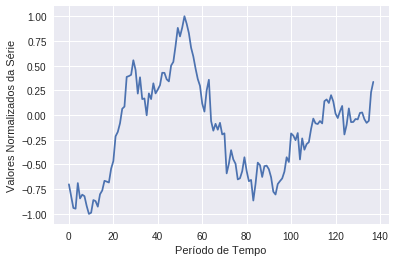

In [3]:
# Plot
plt.plot(dataset)
plt.xlabel('Período de Tempo')
plt.ylabel('Valores Normalizados da Série')

In [4]:
dataset[:5]

array([-0.70062339, -0.82088484, -0.93938305, -0.9471652 , -0.68785527])

## Extraindo Sequências da Série Temporal

Lembre-se, nossa série de tempo é uma sequência de números que podemos representar em termos matemáticos, como:

$$s_{0},s_{1},s_{2},...,s_{P}$$

onde $ s_ {p} $ é o valor numérico das séries temporais no período de tempo $ p $ e onde $ P $ é o comprimento total da série. 

Para aplicar nossa RNN tratamos o problema de previsão de séries temporais como um problema de regressão e, portanto, precisamos usar uma janela deslizante para construir um conjunto de pares de entrada / saída associados para regredir. 

Este processo é representado no gif abaixo.

<img src="https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/RNN/images/timeseries_windowing_training.gif" width=600 height=600/>

Por exemplo - usando uma janela de tamanho T = 5 (como ilustrado no gif acima) produzimos um conjunto de pares de entrada / saída como o mostrado na tabela abaixo

$$
\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Observe aqui que cada entrada é uma sequência (ou vetor) de comprimento 4 (e em geral tem um comprimento igual ao tamanho da janela T), enquanto cada saída correspondente é um valor escalar. Observe também como é dada uma série de tempo de comprimento P e tamanho de janela T = 5 como mostrado acima, criamos pares de entrada / saída P-5. De forma mais geral, para um tamanho de janela T, criamos P-T desses pares.

Abaixo, temos uma função que cria essa janela deslizante.

In [0]:
# Função que transforma séries e window-size em um conjunto de input/output para o modelo RNN 
def window_transform_series(series, window_size):
    """
      Argumentos:
        series(np.array(list)): Sequência de valores
        window_size(int      ): Tamanho da janela
      
      Retorna:
         X(np.array(list(list))): Matriz de Input
         y(np.array(list))      : Array de Ouput
    """

    # Objetos para input/output 
    X = np.asarray([series[i:(i + window_size)] for i in range(len(series) - window_size)])
    y = np.asarray([series[i + window_size] for i in range(len(series) - window_size)])

    return X,y

Aplicamos a função ao nosso conjunto de dados e definimos um windows-size = 7.

In [0]:
window_size = 7
X,y = window_transform_series(series = dataset, window_size = window_size)

In [10]:
np.set_printoptions(precision=3, suppress=True)
X[0]

array([-0.701, -0.821, -0.939, -0.947, -0.688, -0.843, -0.805])

In [11]:
y[0]

-0.820580730773294

In [9]:
len(X)

131

## Dados de Treino e de Teste

Para realizar testes adequados em nosso conjunto de dados, usaremos o último 1/3 dele para teste. Isto é, uma vez que treinamos nosso modelo, temos algo para testá-lo (como qualquer problema de regressão!). Esta divisão em conjuntos de treinamento/teste é feita na célula abaixo.

Observe como aqui ** não ** estamos dividindo o conjunto de dados * aleatoriamente * como normalmente seria feito ao validar um modelo de regressão. Isso ocorre porque nossos pares de entrada/saída * estão relacionados temporariamente *. Não queremos validar o nosso modelo treinando em um subconjunto aleatório da série e depois testar em outro subconjunto aleatório.

Queremos treinar em um pedaço sólido da série (no nosso caso, os primeiros 2/3 completos), e validar em um pedaço posterior (o último 1/3), pois isso simula como prevermos os valores do * futuro * de uma série temporal.

In [0]:
# Split em treino e teste
train_test_split = int(np.ceil(2*len(y)/float(3)))  # Ponto de spplit

# Particiona os dados de treino em X e Y
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# Particiona os dados de teste em X e Y
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# Para criar o Modelo RNN LSTM com o Keras nossos dados precisam estar no formato [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

In [13]:
X_train.shape

(88, 7, 1)

## Construindo o Modelo RNN

Tendo criado pares de entrada / saída de nossas séries temporais e dividido em conjuntos de treinamento / teste, agora podemos começar a configurar nossa RNN. Usamos o Keras para criar rapidamente uma RNN de duas camadas ocultas com as  seguintes especificações

- A camada 1 usa um módulo LSTM com 5 unidades escondidas (observe aqui o input_shape = (window_size, 1))
- A camada 2 usa um módulo totalmente conectado com uma unidade
- A perda 'mean_squared_error' deve ser usada (lembre-se: estamos realizando regressão aqui)

In [0]:
# RNN para regressão em nossos dados de séries temporais 
def build_RNN(window_size):
    model = Sequential()
    model.add(LSTM(5, input_shape=(window_size,1)))
    model.add(Dense(1))
    return model

In [0]:
# Cria e compila o modelo
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# Random seed
np.random.seed(0)

# Build do modelo
model = build_RNN(window_size)

# Otimizador
optimizer = keras.optimizers.RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

# Compila o modelo
model.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


Fit do modelo

In [17]:
model.fit(X_train, y_train, epochs = 1000, batch_size = 50, verbose = 1)

Epoch 1/1000
88/88 [==============================] - 1s 9ms/step - loss: 0.1422
Epoch 2/1000
88/88 [==============================] - 0s 171us/step - loss: 0.1343
Epoch 3/1000
88/88 [==============================] - 0s 138us/step - loss: 0.1290
Epoch 4/1000
88/88 [==============================] - 0s 170us/step - loss: 0.1245
Epoch 5/1000
88/88 [==============================] - 0s 168us/step - loss: 0.1205
Epoch 6/1000
88/88 [==============================] - 0s 161us/step - loss: 0.1169
Epoch 7/1000
88/88 [==============================] - 0s 172us/step - loss: 0.1138
Epoch 8/1000
88/88 [==============================] - 0s 154us/step - loss: 0.1106
Epoch 9/1000
88/88 [==============================] - 0s 156us/step - loss: 0.1078
Epoch 10/1000
88/88 [==============================] - 0s 142us/step - loss: 0.1051
Epoch 11/1000
88/88 [==============================] - 0s 183us/step - loss: 0.1021
Epoch 12/1000
88/88 [==============================] - 0s 183us/step - loss: 0.0994
Epo

In [18]:
X_train.shape

(88, 7, 1)

## Avalia a Performance do Modelo

In [0]:
# Greando previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [20]:
# Print dos erros de treino e de teste
training_error = model.evaluate(X_train, y_train, verbose=0)
print('Erro em Treinamento = %.3f %%' % training_error)

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('Erro em Teste = %.3f %%' %  testing_error)

Erro em Treinamento = 0.016 %
Erro em Teste = 0.014 %


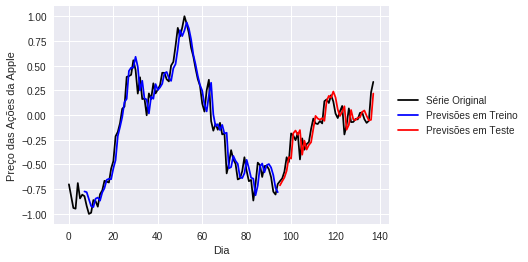

In [21]:
# Plot
import matplotlib.pyplot as plt
%matplotlib inline

# Plot da série original
plt.plot(dataset,color = 'k')

# Plot das previsões em treino
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot das previsões em treino
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# Plot
plt.xlabel('Dia')
plt.ylabel('Preço das Ações da Apple')
plt.legend(['Série Original','Previsões em Treino','Previsões em Teste'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [22]:
len(X)

131

In [23]:
X[130]

array([-0.044,  0.022,  0.026, -0.042, -0.079, -0.058,  0.231])

In [0]:
x

# prever 1 dia pra frente da série - dia 131

In [70]:
dia = 131
X_fut = X[130]
X_fut

array([-0.044,  0.022,  0.026, -0.042, -0.079, -0.058,  0.231])

In [64]:
X_fut.shape

(7, 1)

In [65]:
# ajustar para o keras
X_fut = np.asarray(np.reshape(X_fut, (1, window_size, 1)))
X_fut.shape

(1, 7, 1)

In [66]:
X_fut

array([[[-0.044],
        [ 0.022],
        [ 0.026],
        [-0.042],
        [-0.079],
        [-0.058],
        [ 0.231]]])

In [67]:
predict = model.predict(X_fut)
predict

array([[0.218]], dtype=float32)

In [75]:
dataset[131]

0.021553698235529772

In [77]:
dataset[131] - predict

array([[-0.196]], dtype=float32)